# Project 1 - Gradient Descent Methods - Quasi-Newton Approach
Natalie Pham

$\mathbf{Goal: }$ To solve the optimal control problem
$$ \min_{u \in L^2(\Omega)} J(Y,u) = \frac{1}{2} || y - y_d||^2 + \frac{\gamma}{2} || u ||^2$$
$$ \text{subject to } \begin{cases} -\Delta y = u , & \text{in } \Omega \\ y \big|_{\partial \Omega } = 0 ,& \text{on } \partial \Omega \end{cases}$$

Let $Su = y \Rightarrow f'(u) = S^*(Su - y_d) + \gamma u$, then we have the KKT system:
- State problem: 
$$ \begin{cases} -\Delta y = u , & \text{in } \Omega \\ y  = 0 ,& \text{on } \partial \Omega \end{cases}$$
- Adjoint problem:
$$ \begin{cases} -\Delta p = y - y_d , & \text{in } \Omega \\ p = 0 ,& \text{on } \partial \Omega \end{cases}$$
- Optimality condition: 
$$ p + \gamma u = 0$$

The report presents the Quasi-Newton optimization methods to solve this optimal control problem by approximating the Hessian matrix of the objective function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [2]:
# define objective function
f = lambda u, Yi, yd, gamma: 1/2 * np.linalg.norm(Yi - yd)**2 + gamma/2 * np.linalg.norm(u)**2

In [3]:
def Poisson2DCode1(xl, xr, yb, yt, h, b):
    """
    Finite difference method to solve the Poisson equation. 
    
    :param xl: left boundary
    :param xr: right boundary
    :param yb: bottom boundary
    :param yt: top boundary
    :param b: right-handside vector of the Poisson equation
    :return: mesh solution of the Poisson equation
    """
    
    N = int((xr - xl) / h)
    x = np.linspace(xl, xr, N+1)
    y = np.linspace(yb, yt, N+1)
    A = np.zeros(((N+1)**2, (N+1)**2))
    for i in range(1, N):
        for j in range(1, N):
            A[i + j*(N+1), i - 1 + j*(N+1)] = 1/h**2
            A[i + j*(N+1), i + 1 + j*(N+1)] = 1/h**2
            A[i + j*(N+1), i + j*(N+1)] = -4/h**2
            A[i + j*(N+1), i + (j - 1)*(N+1)] = 1/h**2
            A[i + j*(N+1), i + (j + 1)*(N+1)] = 1/h**2
            
    for i in range(N+1):
        j = 0
        p = i + j*(N+1)
        #A[p, :] = 0
        A[p, p] = 1
        b[p] = 0
        j = N
        q = i + j*(N+1)
        #A[q, :] = 0
        A[q, q] = 1
        b[q] = 0
    for j in range(N+1):
        i = 0
        p = i + j*(N+1)
        #A[p, :] = 0
        A[p, p] = 1
        b[p] = 0
        i = N
        q = i + j*(N+1)
        #A[q, :] = 0
        A[q, q] = 1
        b[q] = 0
    
    #print(A)
    v = np.linalg.solve(-A, b)
    w = np.reshape(v[0:(N+1)**2], (N+1, N+1)).reshape(-1, 1) 
    
    return w

In [4]:
def Poisson2DCode2(xl, xr, yb, yt, h, b):
    """
    Finite difference method to solve the Poisson equation. 
    
    :param xl: left boundary
    :param xr: right boundary
    :param yb: bottom boundary
    :param yt: top boundary
    :param b: right-handside vector of the Poisson equation
    :return: mesh solution of the Poisson equation, matrix A used to solve the Poisson equation
    """

    N = int((xr - xl)/h)
    # setup mesh values
    x = np.linspace(xl, xr, N+1)
    y = np.linspace(yb, yt, N+1)
    
    I = np.eye(N+1)
    e = np.ones(N+1)
    T = np.diag(e[1:], -1) + np.diag(-4*e) + np.diag(e[1:], 1)
    S = np.diag(e[1:], 1) + np.diag(e[1:], -1)
    A = (np.kron(I,T) + np.kron(S,I))/h**2

    for i in range(N+1):
        j = 0
        p = i + j*(N+1)
        A[p, :] = 0
        A[p, p] = 1
        b[p] = 0
        j = N
        q = i + j*(N+1)
        A[q, :] = 0
        A[q, q] = 1
        b[q] = 0
    for j in range(N+1):
        i = 0
        p = i + j*(N+1)
        A[p, :] = 0
        A[p, p] = 1
        b[p] = 0
        i = N
        q = i + j*(N+1)
        A[q, :] = 0
        A[q, q] = 1
        b[q] = 0
        
    # solve for solution in v labeling
    v = np.linalg.solve(-A, b) 
    #print(A)
    
    # translate from v to w
    w = np.reshape(v[0:(N+1)**2], (N+1, N+1)).reshape(-1, 1) 
    
    return w

In [5]:
# Initialize starting condition
xl = 0
xr = 1
yb = 0
yt = 1
h = 0.01 
N = int((xr - xl) / h)
gamma = 10**(-6)

# Initialize maxinum number of iteration to run the algorithms
max_iter = 10

### 1. Quasi-Newton Method

$\mathbf{Algorithm:}$
- Initialize $u_0$, $H_0$, $k = 0$
- While the residual greater than the tolerance or max iteration not yet reached:
    - Compute the gradient $\nabla f(u_k)$
    $$ G_k \approx \nabla f(u_k) = - S^*(y_d - Su_k) + \gamma u_k  $$
    - Compute the search direction $ d_k = - H_k G_k $
    - Compute the step size $\alpha_k$
    $$\alpha_k = \frac{(d_k, b-Au_k)}{(d_k, Ad_k)} = \frac{(d_k, -G_k)}{(Sd_k,Sd_k) + \gamma(d_k, d_k)}$$
    where $ A = S^* S + \gamma I, b = S^* y_d $.
    - Update $u_{k+1} = u_k + \alpha_k d_k$
    - Update $G_{k+1} = - S^* (y_d - Su_{k+1}) + \gamma u_{k+1}$
    - Let $S_k = u_{k+1} - u_k, y_k = \nabla f(u_{k+1}) - \nabla f(u_k) = G_{k+1} - G_k$
    - Update $H_{k+1} = H_k - \frac{H_k y_k y_k^T H_k}{y_k^T H_k y_k} + \frac{s_k s_k^T}{y_k^T s_k}$
    - Increment the iteration $k = k+1$

In [6]:
def QN_exact_search(gamma, h, grad, d, Sd, alpha=1.0):
    """
    Armijo search algorithm for finding the step size that satisfies the Armijo condition in the given direction.

    :param gamma: Parameter in the objective function.
    :param h: Length between 2 consecutive nodes on the mesh
    :param grad: Gradient
    :param d: Search direction
    :param Sd: Matrix of product of the Laplacian and search direction d
    :param alpha: Initial step size. Default is 1.0.
    :return: Step size that satisfies the Armijo condition.
    """
    alpha1 = (h**2)*np.matmul(-grad.T,d)
    alpha2 = (h**2)*np.matmul(Sd.T,Sd)
    alpha = alpha1/(alpha2 + gamma*(h**2)*np.matmul(d.T,d))
    return alpha

In [7]:
u = np.zeros(((N+1)**2,1))
x = np.linspace(xl, xr, N+1)
y = np.linspace(yb, yt, N+1)
X, Y = np.meshgrid(x, y)
yde = X*Y*(X-1)*(Y-1) 
yd = yde.reshape(-1,1)
residual = 1 
tol = 10**(-6) 
iteration = 1 
H = np.identity((N+1)**2)
Yk = Poisson2DCode1(xl,xr,yb,yt,h,u)
P = Poisson2DCode1(xl,xr,yb,yt,h,Yk-yd)
grad = P + gamma*u
print(grad.shape)
print(H.shape)
print(N)

(10201, 1)
(10201, 10201)
100


In [8]:
start = time.time()
for iteration in tqdm(range(max_iter)):
    # compute the descent direction
    d = - np.matmul(H,grad)
    # compute the step size alpha
    Sd = Poisson2DCode1(xl,xr,yb,yt,h,d)
    alpha = QN_exact_search(gamma, h, grad, d, Sd)
    # update u
    u = u + alpha*d
    # compute the new gradient
    Yk = Poisson2DCode1(xl,xr,yb,yt,h,u)
    P = Poisson2DCode1(xl,xr,yb,yt,h,Yk-yd)
    grad_new = P + gamma*u
    # update the inverse Hessians matrix
    y_k = grad_new - grad
    s_k = alpha*d
    Hy_k = np.matmul(H,y_k)
    vvT = np.matmul(Hy_k,Hy_k.T)/np.matmul(y_k.T,Hy_k)
    wwT = np.matmul(s_k,s_k.T)/np.matmul(y_k.T,s_k)
    H = H - vvT + wwT
    grad = grad_new
    # compute the residual
    residual = h*np.linalg.norm(grad)
    print(iteration, residual)
    if residual < tol:
        break

end = time.time()
print('Time taken: ', end-start)

 10%|████████▎                                                                          | 1/10 [01:04<09:41, 64.63s/it]

0 1.7030074007598282e-05


 20%|████████████████▌                                                                  | 2/10 [02:12<08:53, 66.69s/it]

1 1.2793784030276966e-06


 20%|████████████████▍                                                                 | 2/10 [04:03<16:15, 121.91s/it]

2 4.3183325999648644e-07
Time taken:  243.99746656417847


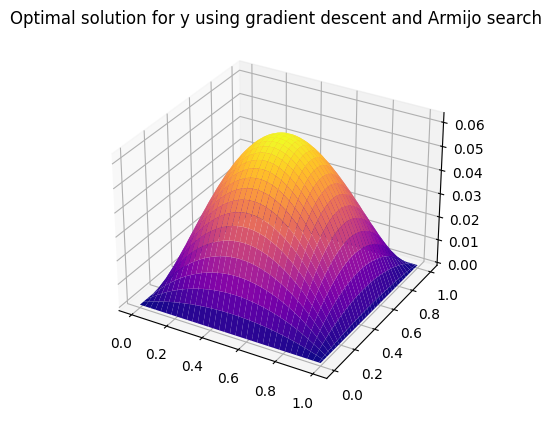

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Yk.reshape(N+1,N+1), cmap='plasma')
ax.set_title('Optimal solution for y using gradient descent and Armijo search')
plt.savefig('quasi-newton_gd_y.png')
plt.show()

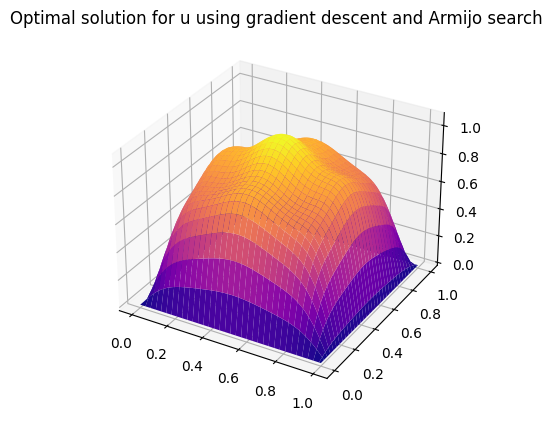

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u.reshape(N+1,N+1), cmap='plasma')
ax.set_title('Optimal solution for u using gradient descent and Armijo search')
plt.savefig('quasi-newton_gd_u.png')
plt.show()

In [11]:
print(iteration,residual)

2 4.3183325999648644e-07
